In [1]:
from __future__ import absolute_import, division, print_function

import csv
import os
import random
import pickle
import sys
import numpy as np
from typing import *

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score

import wandb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from torch.nn import CrossEntropyLoss, L1Loss, MSELoss
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import matthews_corrcoef
from transformers import BertTokenizer, XLNetTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from transformers.models.bert.configuration_bert import BertConfig
from transformers.optimization import AdamW
from bert import MAG_BertForSequenceClassification
from xlnet import MAG_XLNetForSequenceClassification

from argparse_utils import str2bool, seed
from global_configs import ACOUSTIC_DIM, VISUAL_DIM, DEVICE

In [2]:
import easydict

args = easydict.EasyDict({
    "dataset": "mosi",
    "max_seq_length": 50,
    "train_batch_size": 48,
    "dev_batch_size" : 128,
    "test_batch_size": 128,
    "n_epochs": 40,
    "beta_shift": 1.0,
    "dropout_prob": 0.5,
    "model": "bert-base-uncased",
    "learning_rate": 1e-5,
    "gradient_accumulation_step": 1,
    "warmup_proportion": 0.1,
    "seed": seed("random")
})

In [3]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, visual, acoustic, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.visual = visual
        self.acoustic = acoustic
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

In [4]:
class MultimodalConfig(object):
    def __init__(self, beta_shift, dropout_prob):
        self.beta_shift = beta_shift
        self.dropout_prob = dropout_prob

In [5]:
def convert_to_features(examples, max_seq_length, tokenizer):
    features = []

    for (ex_index, example) in enumerate(examples):

        (words, visual, acoustic), label_id, segment = example

        tokens, inversions = [], []
        for idx, word in enumerate(words):
            tokenized = tokenizer.tokenize(word)
            tokens.extend(tokenized)
            inversions.extend([idx] * len(tokenized))

        # Check inversion
        assert len(tokens) == len(inversions)

        aligned_visual = []
        aligned_audio = []

        for inv_idx in inversions:
            aligned_visual.append(visual[inv_idx, :])
            aligned_audio.append(acoustic[inv_idx, :])

        visual = np.array(aligned_visual)
        acoustic = np.array(aligned_audio)

        # Truncate input if necessary
        if len(tokens) > max_seq_length - 2:
            tokens = tokens[: max_seq_length - 2]
            acoustic = acoustic[: max_seq_length - 2]
            visual = visual[: max_seq_length - 2]

        if args.model == "bert-base-uncased":
            prepare_input = prepare_bert_input
        elif args.model == "xlnet-base-cased":
            prepare_input = prepare_xlnet_input

        input_ids, visual, acoustic, input_mask, segment_ids = prepare_input(
            tokens, visual, acoustic, tokenizer
        )

        # Check input length
        assert len(input_ids) == args.max_seq_length
        assert len(input_mask) == args.max_seq_length
        assert len(segment_ids) == args.max_seq_length
        assert acoustic.shape[0] == args.max_seq_length
        assert visual.shape[0] == args.max_seq_length

        features.append(
            InputFeatures(
                input_ids=input_ids,
                input_mask=input_mask,
                segment_ids=segment_ids,
                visual=visual,
                acoustic=acoustic,
                label_id=label_id,
            )
        )
    return features


def prepare_bert_input(tokens, visual, acoustic, tokenizer):
    CLS = tokenizer.cls_token
    SEP = tokenizer.sep_token
    tokens = [CLS] + tokens + [SEP]

    # Pad zero vectors for acoustic / visual vectors to account for [CLS] / [SEP] tokens
    acoustic_zero = np.zeros((1, ACOUSTIC_DIM))
    acoustic = np.concatenate((acoustic_zero, acoustic, acoustic_zero))
    visual_zero = np.zeros((1, VISUAL_DIM))
    visual = np.concatenate((visual_zero, visual, visual_zero))

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    segment_ids = [0] * len(input_ids)
    input_mask = [1] * len(input_ids)

    pad_length = args.max_seq_length - len(input_ids)

    acoustic_padding = np.zeros((pad_length, ACOUSTIC_DIM))
    acoustic = np.concatenate((acoustic, acoustic_padding))

    visual_padding = np.zeros((pad_length, VISUAL_DIM))
    visual = np.concatenate((visual, visual_padding))

    padding = [0] * pad_length

    # Pad inputs
    input_ids += padding
    input_mask += padding
    segment_ids += padding

    return input_ids, visual, acoustic, input_mask, segment_ids


def prepare_xlnet_input(tokens, visual, acoustic, tokenizer):
    CLS = tokenizer.cls_token
    SEP = tokenizer.sep_token
    PAD_ID = tokenizer.pad_token_id

    # PAD special tokens
    tokens = tokens + [SEP] + [CLS]
    audio_zero = np.zeros((1, ACOUSTIC_DIM))
    acoustic = np.concatenate((acoustic, audio_zero, audio_zero))
    visual_zero = np.zeros((1, VISUAL_DIM))
    visual = np.concatenate((visual, visual_zero, visual_zero))

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)
    segment_ids = [0] * (len(tokens) - 1) + [2]

    pad_length = (args.max_seq_length - len(segment_ids))

    # then zero pad the visual and acoustic
    audio_padding = np.zeros((pad_length, ACOUSTIC_DIM))
    acoustic = np.concatenate((audio_padding, acoustic))

    video_padding = np.zeros((pad_length, VISUAL_DIM))
    visual = np.concatenate((video_padding, visual))

    input_ids = [PAD_ID] * pad_length + input_ids
    input_mask = [0] * pad_length + input_mask
    segment_ids = [3] * pad_length + segment_ids

    return input_ids, visual, acoustic, input_mask, segment_ids


def get_tokenizer(model):
    if model == "bert-base-uncased":
        return BertTokenizer.from_pretrained(model)
    elif model == "xlnet-base-cased":
        return XLNetTokenizer.from_pretrained(model)
    else:
        raise ValueError(
            "Expected 'bert-base-uncased' or 'xlnet-base-cased, but received {}".format(
                model
            )
        )


def get_appropriate_dataset(data):

    tokenizer = get_tokenizer(args.model)

    features = convert_to_features(data, args.max_seq_length, tokenizer)
    all_input_ids = torch.tensor(
        [f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor(
        [f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor(
        [f.segment_ids for f in features], dtype=torch.long)
    all_visual = torch.tensor([f.visual for f in features], dtype=torch.float)
    all_acoustic = torch.tensor(
        [f.acoustic for f in features], dtype=torch.float)
    all_label_ids = torch.tensor(
        [f.label_id for f in features], dtype=torch.float)

    dataset = TensorDataset(
        all_input_ids,
        all_visual,
        all_acoustic,
        all_input_mask,
        all_segment_ids,
        all_label_ids,
    )
    return dataset, tokenizer


def set_up_data_loader():
    with open(f"../datasets/{args.dataset}.pkl", "rb") as handle:
        data = pickle.load(handle)

    train_data = data["train"]
    dev_data = data["dev"]
    test_data = data["test"]

    train_dataset, train_tokenizer = get_appropriate_dataset(train_data)
    dev_dataset, dev_tokenizer = get_appropriate_dataset(dev_data)
    test_dataset, test_tokenizer = get_appropriate_dataset(test_data)

    num_train_optimization_steps = (
        int(
            len(train_dataset) / args.train_batch_size /
            args.gradient_accumulation_step
        )
        * args.n_epochs
    )

    train_dataloader = DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True
    )

    dev_dataloader = DataLoader(
        dev_dataset, batch_size=args.dev_batch_size, shuffle=True
    )

    test_dataloader = DataLoader(
        test_dataset, batch_size=args.test_batch_size, shuffle=True,
    )

    return (
        train_dataloader,
        dev_dataloader,
        test_dataloader,
        num_train_optimization_steps,
        train_tokenizer,
        dev_tokenizer,
        test_tokenizer
    )


def set_random_seed(seed: int):
    """
    Helper function to seed experiment for reproducibility.
    If -1 is provided as seed, experiment uses random seed from 0~9999

    Args:
        seed (int): integer to be used as seed, use -1 to randomly seed experiment
    """
    print("Seed: {}".format(seed))

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def prep_for_training(num_train_optimization_steps: int):
    multimodal_config = MultimodalConfig(
        beta_shift=args.beta_shift, dropout_prob=args.dropout_prob
    )
    bert_config = BertConfig(
        hidden_dropout_prob=args.dropout_prob
    )

    if args.model == "bert-base-uncased":
        model = MAG_BertForSequenceClassification.from_pretrained(
            args.model, multimodal_config=multimodal_config, num_labels=1,
        )
        # model = BertForSequenceClassification.from_pretrained(
        #     args.model,
        #     num_labels = 1
        # )
    elif args.model == "xlnet-base-cased":
        model = MAG_XLNetForSequenceClassification.from_pretrained(
            args.model, multimodal_config=multimodal_config, num_labels=1
        )

    model.to(DEVICE)

    # Prepare optimizer
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.01,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_train_optimization_steps,
        num_training_steps=args.warmup_proportion * num_train_optimization_steps,
    )
    return model, optimizer, scheduler


def train_epoch(model: nn.Module, train_dataloader: DataLoader, optimizer, scheduler):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(DEVICE) for t in batch)
        input_ids, visual, acoustic, input_mask, segment_ids, label_ids = batch
        visual = torch.squeeze(visual, 1)
        acoustic = torch.squeeze(acoustic, 1)
        model.zero_grad()
        outputs = model(
            input_ids,
            visual,
            acoustic,
            token_type_ids=segment_ids,
            attention_mask=input_mask,
            labels=None
        )

        logits = outputs[0]
        loss_fct = MSELoss()
        loss = loss_fct(logits.view(-1), label_ids.view(-1))

        if args.gradient_accumulation_step > 1:
            loss = loss / args.gradient_accumulation_step

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        tr_loss += loss.item()
        nb_tr_steps += 1

        if (step + 1) % args.gradient_accumulation_step == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

    return tr_loss / nb_tr_steps


def eval_epoch(model: nn.Module, dev_dataloader: DataLoader, optimizer):
    model.eval()
    dev_loss = 0
    nb_dev_examples, nb_dev_steps = 0, 0
    with torch.no_grad():
        for step, batch in enumerate(tqdm(dev_dataloader, desc="Iteration")):
            batch = tuple(t.to(DEVICE) for t in batch)

            input_ids, visual, acoustic, input_mask, segment_ids, label_ids = batch
            visual = torch.squeeze(visual, 1)
            acoustic = torch.squeeze(acoustic, 1)
            outputs = model(
                input_ids,
                visual,
                acoustic,
                token_type_ids=segment_ids,
                attention_mask=input_mask,
                labels=None
            )
            logits = outputs[0]

            loss_fct = MSELoss()
            loss = loss_fct(logits.view(-1), label_ids.view(-1))

            if args.gradient_accumulation_step > 1:
                loss = loss / args.gradient_accumulation_step

            dev_loss += loss.item()
            nb_dev_steps += 1

    return dev_loss / nb_dev_steps


def test_epoch(model: nn.Module, test_dataloader: DataLoader, tokenizer):
    model.eval()
    preds = []
    labels = []
    
    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_dataloader)):
            batch = tuple(t.to(DEVICE) for t in batch)

            input_ids, visual, acoustic, input_mask, segment_ids, label_ids = batch
            visual = torch.squeeze(visual, 1)
            acoustic = torch.squeeze(acoustic, 1)
            outputs = model(
                input_ids,
                visual,
                acoustic,
                token_type_ids=segment_ids,
                attention_mask=input_mask,
                labels=None
            )

            logits = outputs[0]

            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.detach().cpu().numpy()

            logits = np.squeeze(logits).tolist()
            label_ids = np.squeeze(label_ids).tolist()

            preds.extend(logits)
            labels.extend(label_ids)

            # print(i, " th batch")
            # for i, s in enumerate(input_ids):
            #     tokens = tokenizer.convert_ids_to_tokens(s, skip_special_tokens = True)
            #     print(tokens, logits[i], label_ids[i])

        preds = np.array(preds)
        labels = np.array(labels)

        # for s in input_ids:
        #     tokens = tokenizer.convert_ids_to_tokens(s)
        #     print(tokens)
        # print(preds)
        # print(labels)
        # print("--------------------------------------------------------------------")

    return preds, labels


def test_score_model(model: nn.Module, test_dataloader: DataLoader, tokenizer, use_zero=False):

    preds, y_test = test_epoch(model, test_dataloader, tokenizer)
    non_zeros = np.array(
        [i for i, e in enumerate(y_test) if e != 0 or use_zero])

    preds = preds[non_zeros]
    y_test = y_test[non_zeros]

    mae = np.mean(np.absolute(preds - y_test))
    corr = np.corrcoef(preds, y_test)[0][1]

    preds = preds >= 0
    y_test = y_test >= 0

    f_score = f1_score(y_test, preds, average="weighted")
    acc = accuracy_score(y_test, preds)

    return acc, mae, corr, f_score


def test_instance(model: nn.Module, test_tokenizer):
    model.eval()
    segment_list = []
    words_list = []
    preds = []
    preds_2 = []
    preds_7 = []
    labels = []
    labels_2 = []
    labels_7 = []

    with open(f"../datasets/{args.dataset}.pkl", "rb") as handle:
        data = pickle.load(handle)

    # test_data[idx] = (words, visual, acoustic), label, segment
    test_data = data["test"]
    test_dataset, test_tokenizer = get_appropriate_dataset(test_data)
    test_dataloader = DataLoader(
        test_dataset, batch_size=args.test_batch_size, shuffle=False,
    )

    video = set()
    count = 0

    for idx in range(len(test_data)):
        (words, visual, acoustic), label, segment = test_data[idx]
        if args.dataset == 'mosi':
            segment_list.append(segment)
        else:
            video_name = segment[0]
            if video_name in video:
                count += 1
            else:
                video.add(video_name)
                count = 0
            segment_list.append(video_name + '[' + str(count) + ']')

        words_list.append(words)
        labels.append(label[0][0])

        # label_2 appending
        if label > 0:
            labels_2.append('positive')
        else:
            labels_2.append('negative')
        
        # label_7 appending
        if label < -15/7:
            labels_7.append('very negative')
        elif label < -9/7:
            labels_7.append('negative')
        elif label < -3/7:
            labels_7.append('slightly negative')
        elif label < 3/7:
            labels_7.append('Neutral')
        elif label < 9/7:
            labels_7.append('slightly positive')
        elif label < 15/7:
            labels_7.append('positive')
        else:
            labels_7.append('very positive')
            
    # prediction
    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_dataloader)):
            batch = tuple(t.to(DEVICE) for t in batch)

            input_ids, visual, acoustic, input_mask, segment_ids, label_ids = batch
            visual = torch.squeeze(visual, 1)
            acoustic = torch.squeeze(acoustic, 1)
            outputs = model(
                input_ids,
                visual,
                acoustic,
                token_type_ids=segment_ids,
                attention_mask=input_mask,
                labels=None
            )
            logits = outputs[0]

            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.detach().cpu().numpy()

            logits = np.squeeze(logits).tolist()
            label_ids = np.squeeze(label_ids).tolist()

            preds.extend(logits)

            for logit in logits:
                # preds_2 appending
                if logit > 0:
                    preds_2.append('positive')
                else:
                    preds_2.append('negative')

                # label_7 appending
                if logit < -15/7:
                    preds_7.append('very negative')
                elif logit < -9/7:
                    preds_7.append('negative')
                elif logit < -3/7:
                    preds_7.append('slightly negative')
                elif logit < 3/7:
                    preds_7.append('Neutral')
                elif logit < 9/7:
                    preds_7.append('slightly positive')
                elif logit < 15/7:
                    preds_7.append('positive')
                else:
                    preds_7.append('very positive')

            

    count = 0
    for i in range(len(segment_list)):
        print(i, "th data")
        print(segment_list[i])
        print(words_list[i])
        print(labels[i])
        print(labels_2[i])
        print(labels_7[i])
        print(preds[i])
        print(preds_2[i])
        print(preds_7[i])


def train(
    model,
    train_dataloader,
    validation_dataloader,
    test_data_loader,
    optimizer,
    scheduler,
    tokenizer
):
    valid_losses = []
    test_accuracies = []

    for epoch_i in range(int(args.n_epochs)):
        train_loss = train_epoch(model, train_dataloader, optimizer, scheduler)
        valid_loss = eval_epoch(model, validation_dataloader, optimizer)
        test_acc, test_mae, test_corr, test_f_score = test_score_model(
            model, test_data_loader, tokenizer
        )

        print(
            "epoch:{}, train_loss:{}, valid_loss:{}, test_acc:{}".format(
                epoch_i, train_loss, valid_loss, test_acc
            )
        )

        valid_losses.append(valid_loss)
        test_accuracies.append(test_acc)
    
    print("Total Result:")
    print("best_accuracy: ", sorted(test_accuracies)[-1])
    print("best loss: ", sorted(valid_losses)[0])
    
    return model


In [6]:
set_random_seed(args.seed)

Seed: 2530


In [7]:
(
    train_data_loader,
    dev_data_loader,
    test_data_loader,
    num_train_optimization_steps,
    train_tokenizer,
    dev_tokenizer,
    test_tokenizer
) = set_up_data_loader()

model, optimizer, scheduler = prep_for_training(
    num_train_optimization_steps)

model = train(
    model,
    train_data_loader,
    dev_data_loader,
    test_data_loader,
    optimizer,
    scheduler,
    test_tokenizer
)

/mnt/soyeon/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:151: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)


Initializing MAG with beta_shift:1.0 hidden_prob:0.5


Some weights of the model checkpoint at bert-base-uncased were not used when initializing MAG_BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing MAG_BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MAG_BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MAG_BertForSequenceClassification were not initialized from the mod

epoch:0, train_loss:2.3206628296110363, valid_loss:2.7822484970092773, test_acc:0.4198473282442748


100%|██████████| 6/6 [00:00<00:00, 20.07it/s]


epoch:1, train_loss:2.2976633133711637, valid_loss:2.7759132385253906, test_acc:0.4198473282442748


100%|██████████| 6/6 [00:00<00:00, 19.99it/s]


epoch:2, train_loss:2.289775667367158, valid_loss:2.7849926948547363, test_acc:0.4213740458015267


100%|██████████| 6/6 [00:00<00:00, 19.89it/s]


epoch:3, train_loss:2.286577264467875, valid_loss:2.7472140789031982, test_acc:0.4213740458015267


100%|██████████| 6/6 [00:00<00:00, 19.91it/s]


epoch:4, train_loss:2.2762422605797097, valid_loss:2.7410327196121216, test_acc:0.4213740458015267


100%|██████████| 6/6 [00:00<00:00, 19.87it/s]


epoch:5, train_loss:2.2380913849230164, valid_loss:2.69174861907959, test_acc:0.42290076335877863


100%|██████████| 6/6 [00:00<00:00, 19.80it/s]


epoch:6, train_loss:2.201779462673046, valid_loss:2.6395031213760376, test_acc:0.42442748091603055


100%|██████████| 6/6 [00:00<00:00, 19.50it/s]


epoch:7, train_loss:2.1346375898078636, valid_loss:2.6643381118774414, test_acc:0.42748091603053434


100%|██████████| 6/6 [00:00<00:00, 19.77it/s]


epoch:8, train_loss:2.0455225573645697, valid_loss:2.5028891563415527, test_acc:0.45648854961832064


100%|██████████| 6/6 [00:00<00:00, 19.64it/s]


epoch:9, train_loss:1.970657295650906, valid_loss:2.376025915145874, test_acc:0.4961832061068702


100%|██████████| 6/6 [00:00<00:00, 19.67it/s]


epoch:10, train_loss:1.8518164334473786, valid_loss:2.2400037050247192, test_acc:0.5572519083969466


100%|██████████| 6/6 [00:00<00:00, 19.64it/s]


epoch:11, train_loss:1.6677838299009535, valid_loss:1.9747759103775024, test_acc:0.6152671755725191


100%|██████████| 6/6 [00:00<00:00, 19.61it/s]


epoch:12, train_loss:1.509188179616575, valid_loss:1.6666821837425232, test_acc:0.7526717557251908


100%|██████████| 6/6 [00:00<00:00, 19.52it/s]


epoch:13, train_loss:1.4208437138133578, valid_loss:1.5167560577392578, test_acc:0.7725190839694657


100%|██████████| 6/6 [00:00<00:00, 19.53it/s]


epoch:14, train_loss:1.303062739195647, valid_loss:1.4173136353492737, test_acc:0.7908396946564885


100%|██████████| 6/6 [00:00<00:00, 19.52it/s]


epoch:15, train_loss:1.2421681262828685, valid_loss:1.3989813923835754, test_acc:0.7603053435114504


100%|██████████| 6/6 [00:00<00:00, 19.39it/s]


epoch:16, train_loss:1.2017787319642526, valid_loss:1.346500277519226, test_acc:0.7847328244274809


100%|██████████| 6/6 [00:00<00:00, 19.50it/s]


epoch:17, train_loss:1.10416841506958, valid_loss:1.251146674156189, test_acc:0.8122137404580153


100%|██████████| 6/6 [00:00<00:00, 15.85it/s]


epoch:18, train_loss:1.0039667310538116, valid_loss:1.250343680381775, test_acc:0.8106870229007633


100%|██████████| 6/6 [00:00<00:00, 19.43it/s]


epoch:19, train_loss:0.9354974914480139, valid_loss:1.250982403755188, test_acc:0.8106870229007633


100%|██████████| 6/6 [00:00<00:00, 19.42it/s]


epoch:20, train_loss:0.9043353398640951, valid_loss:1.2346599698066711, test_acc:0.816793893129771


100%|██████████| 6/6 [00:00<00:00, 19.45it/s]


epoch:21, train_loss:0.8621612897625676, valid_loss:1.2318817973136902, test_acc:0.8091603053435115


100%|██████████| 6/6 [00:00<00:00, 19.39it/s]


epoch:22, train_loss:0.8613306173571834, valid_loss:1.249707281589508, test_acc:0.8030534351145038


100%|██████████| 6/6 [00:00<00:00, 19.41it/s]


epoch:23, train_loss:0.7729315084439737, valid_loss:1.217372715473175, test_acc:0.8122137404580153


100%|██████████| 6/6 [00:00<00:00, 19.38it/s]


epoch:24, train_loss:0.7728768631264016, valid_loss:1.2711506485939026, test_acc:0.7984732824427481


100%|██████████| 6/6 [00:00<00:00, 19.38it/s]


epoch:25, train_loss:0.6941362630437922, valid_loss:1.2174089550971985, test_acc:0.8091603053435115


100%|██████████| 6/6 [00:00<00:00, 19.35it/s]


epoch:26, train_loss:0.668689481638096, valid_loss:1.2642387747764587, test_acc:0.7908396946564885


100%|██████████| 6/6 [00:00<00:00, 19.33it/s]


epoch:27, train_loss:0.6646923345548136, valid_loss:1.2015110850334167, test_acc:0.8137404580152672


100%|██████████| 6/6 [00:00<00:00, 19.35it/s]


epoch:28, train_loss:0.6053348558920401, valid_loss:1.259284645318985, test_acc:0.7984732824427481


100%|██████████| 6/6 [00:00<00:00, 19.32it/s]


epoch:29, train_loss:0.5730400361396648, valid_loss:1.2247944474220276, test_acc:0.8183206106870229


100%|██████████| 6/6 [00:00<00:00, 19.34it/s]


epoch:30, train_loss:0.5381483832995096, valid_loss:1.2177898287773132, test_acc:0.8076335877862595


100%|██████████| 6/6 [00:00<00:00, 19.33it/s]


epoch:31, train_loss:0.5250439445177714, valid_loss:1.2628591656684875, test_acc:0.8076335877862595


100%|██████████| 6/6 [00:00<00:00, 19.25it/s]


epoch:32, train_loss:0.453598032395045, valid_loss:1.263220489025116, test_acc:0.8198473282442749


100%|██████████| 6/6 [00:00<00:00, 19.16it/s]


epoch:33, train_loss:0.42017678198991, valid_loss:1.207796424627304, test_acc:0.7969465648854962


100%|██████████| 6/6 [00:00<00:00, 19.17it/s]


epoch:34, train_loss:0.3883508929499873, valid_loss:1.2557894587516785, test_acc:0.8091603053435115


100%|██████████| 6/6 [00:00<00:00, 19.20it/s]


epoch:35, train_loss:0.42076987911153724, valid_loss:1.197403907775879, test_acc:0.815267175572519


100%|██████████| 6/6 [00:00<00:00, 19.25it/s]


epoch:36, train_loss:0.3548144742294594, valid_loss:1.2059151530265808, test_acc:0.8274809160305343


100%|██████████| 6/6 [00:00<00:00, 19.13it/s]


epoch:37, train_loss:0.3272902496435024, valid_loss:1.2002331614494324, test_acc:0.8137404580152672


100%|██████████| 6/6 [00:00<00:00, 19.18it/s]


epoch:38, train_loss:0.3214496688710319, valid_loss:1.1988521218299866, test_acc:0.8259541984732824


100%|██████████| 6/6 [00:00<00:00, 19.24it/s]


epoch:39, train_loss:0.2986190655717143, valid_loss:1.1784008145332336, test_acc:0.8259541984732824
Total Result:
best_accuracy:  0.8274809160305343
best loss:  1.1784008145332336


### Model Save and Load

In [13]:
torch.save(model.state_dict(), "./saved_models_MAG_mosi.pt")

In [14]:
multimodal_config = MultimodalConfig(beta_shift=args.beta_shift, dropout_prob=args.dropout_prob)
bert_config = BertConfig(hidden_dropout_prob=args.dropout_prob)
model = MAG_BertForSequenceClassification.from_pretrained(args.model, multimodal_config=multimodal_config, num_labels=1)
model.load_state_dict(torch.load("./saved_models_MAG_mosi.pt"))
model.eval()

Initializing MAG with beta_shift:1.0 hidden_prob:0.5


Some weights of the model checkpoint at bert-base-uncased were not used when initializing MAG_BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing MAG_BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MAG_BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MAG_BertForSequenceClassification were not initialized from the mod

MAG_BertForSequenceClassification(
  (bert): MAG_BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Sentiment Intensity Reflection of Fustion Embedding Space

In [13]:
with open(f"../datasets/{args.dataset}.pkl", "rb") as handle:
    data = pickle.load(handle)

train_data = data["train"]
dev_data = data["dev"]
test_data = data["test"]

train_dataset, train_tokenizer = get_appropriate_dataset(train_data)
dev_dataset, dev_tokenizer = get_appropriate_dataset(dev_data)
test_dataset, test_tokenizer = get_appropriate_dataset(test_data)

test_data_loader = DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False)

model.eval()

test_embeddings = torch.zeros((0, 100), dtype=torch.float32)
preds = []
labels = []
classes = []
pred_classes = []

# Gold 7-Class
for idx in range(len(test_data)):
    (word, visual, acoustic), label, segment = test_data[idx]
    if label < -15/7:
        classes.append(-3)
    elif label < -9/7:
        classes.append(-2)
    elif label < -3/7:
        classes.append(-1)
    elif label < 3/7:
        classes.append(0)
    elif label < 9/7:
        classes.append(1)
    elif label < 15/7:
        classes.append(2)
    else:
        classes.append(3)
classes = np.array(classes)

# MAG-BERT Model output
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_data_loader)):
        batch = tuple(t.to(DEVICE) for t in batch)

        input_ids, visual, acoustic, input_mask, segment_ids, label_ids = batch
        visual = torch.squeeze(visual, 1)
        acoustic = torch.squeeze(acoustic, 1)
        outputs = model(
            input_ids,
            visual,
            acoustic,
            token_type_ids=segment_ids,
            attention_mask=input_mask,
            labels=None
        )

        logits = outputs[0]
        embeddings = outputs[1:]

        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)

        logits = logits.detach().cpu().numpy()
        label_ids = label_ids.detach().cpu().numpy()

        preds.extend(np.squeeze(logits).tolist())
        labels.extend(np.squeeze(label_ids).tolist())

        preds = np.array(preds)
        labels = np.array(labels)

        # 7-class prediction
        for logit in logits:
            if logit < -15/7:
                pred_classes.append(-3)
            elif logit < -9/7:
                pred_classes.append(-2)
            elif logit < -3/7:
                pred_classes.append(-1)
            elif logit < 3/7:
                pred_classes.append(0)
            elif logit < 9/7:
                pred_classes.append(1)
            elif logit < 15/7:
                pred_classes.append(2)
            else:
                pred_classes.append(3)
        pred_classes = np.array(pred_classes)
    
    

  0%|          | 0/6 [00:00<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'detach'

In [ ]:
# Create a two dimensional t-SNE projection of the embeddings
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from sklearn.manifold import TSNE

tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplot(figsize=(8,8))
# num_categories = 7
for lab in range(-3, 3):
    indices = pred_classes==lab
    

### Test Instance Prediction Result

In [17]:
def test_instance(model: nn.Module):
    model.eval()
    segment_list = []
    words_list = []
    preds = []
    preds_2 = []
    preds_7 = []
    labels = []
    labels_2 = []
    labels_7 = []

    with open(f"../datasets/{args.dataset}.pkl", "rb") as handle:
        data = pickle.load(handle)

    # test_data[idx] = (words, visual, acoustic), label, segment
    test_data = data["test"]
    test_dataset, test_tokenizer = get_appropriate_dataset(test_data)
    test_dataloader = DataLoader(
        test_dataset, batch_size=args.test_batch_size, shuffle=False,
    )

    video = set()
    count = 0

    for idx in range(len(test_data)):
        (words, visual, acoustic), label, segment = test_data[idx]
        if args.dataset == 'mosi':
            segment_list.append(segment)
        else:
            video_name = segment[0]
            if video_name in video:
                count += 1
            else:
                video.add(video_name)
                count = 0
            segment_list.append(video_name + '[' + str(count) + ']')

        words_list.append(words)
        labels.append(label[0][0])

        # label_2 appending
        if label > 0:
            labels_2.append('positive')
        else:
            labels_2.append('negative')
        
        # label_7 appending
        if label < -15/7:
            labels_7.append('very negative')
        elif label < -9/7:
            labels_7.append('negative')
        elif label < -3/7:
            labels_7.append('slightly negative')
        elif label < 3/7:
            labels_7.append('Neutral')
        elif label < 9/7:
            labels_7.append('slightly positive')
        elif label < 15/7:
            labels_7.append('positive')
        else:
            labels_7.append('very positive')
            
    # prediction
    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_dataloader)):
            batch = tuple(t.to(DEVICE) for t in batch)

            input_ids, visual, acoustic, input_mask, segment_ids, label_ids = batch
            visual = torch.squeeze(visual, 1)
            acoustic = torch.squeeze(acoustic, 1)
            outputs = model(
                input_ids,
                visual,
                acoustic,
                token_type_ids=segment_ids,
                attention_mask=input_mask,
                labels=None
            )
            logits = outputs[0]

            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.detach().cpu().numpy()

            logits = np.squeeze(logits).tolist()
            label_ids = np.squeeze(label_ids).tolist()

            preds.extend(logits)

            for logit in logits:
                # preds_2 appending
                if logit > 0:
                    preds_2.append('positive')
                else:
                    preds_2.append('negative')

                # label_7 appending
                if logit < -15/7:
                    preds_7.append('very negative')
                elif logit < -9/7:
                    preds_7.append('negative')
                elif logit < -3/7:
                    preds_7.append('slightly negative')
                elif logit < 3/7:
                    preds_7.append('Neutral')
                elif logit < 9/7:
                    preds_7.append('slightly positive')
                elif logit < 15/7:
                    preds_7.append('positive')
                else:
                    preds_7.append('very positive')

                # if logit < -15/7:
                #     preds_7.append('-3')
                # elif logit < -9/7:
                #     preds_7.append('-2')
                # elif logit < -3/7:
                #     preds_7.append('-1')
                # elif logit < 3/7:
                #     preds_7.append('0')
                # elif logit < 9/7:
                #     preds_7.append('1')
                # elif logit < 15/7:
                #     preds_7.append('2')
                # else:
                #     preds_7.append('3')

            

    count = 0
    # for i in range(len(segment_list)):
    #     print(i, "th data")
    #     print(segment_list[i])
    #     print(words_list[i])
    #     print(labels[i])
    #     print(labels_2[i])
    #     print(labels_7[i])
    #     print(preds[i])
    #     print(preds_2[i])
    #     print(preds_7[i])

    return segment_list, words_list, labels, labels_2, labels_7, preds, preds_2, preds_7


In [19]:
model = model.to(DEVICE)
segment_list, words_list, labels, labels_2, labels_7, preds, preds_2, preds_7 = test_instance(model=model)

100%|██████████| 6/6 [00:00<00:00, 20.08it/s]


In [20]:
from ipywidgets import interact

@interact
def get_predict_result(idx = range(len(segment_list))):
    print("SEGMENT:", segment_list[idx])
    print("WORDS:", words_list[idx])
    print("GOLD_VALUE:", labels[idx])
    print("GOLD_BINARY:", labels_2[idx])
    print("GOLD_7_CLASS:", labels_7[idx])
    print("PREDICTED_VALUE:", preds[idx])
    print("PREDICTED_BINARY:", preds_2[idx])
    print("PREDICTED _7_CLASS:", preds_7[idx])

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

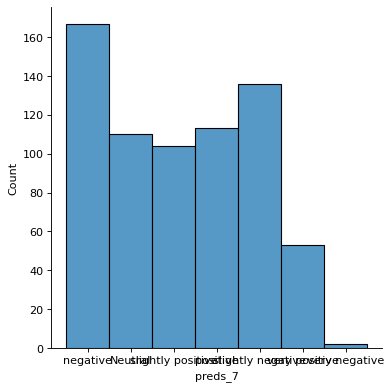

In [22]:
import seaborn as sns
import pandas as pd
d = {'segmentID': segment_list, 'words': words_list, 'labels': labels, 'labels_2': labels_2, 'labels_7': labels_7, 'preds': preds, 'preds_2': preds_2, 'preds_7': preds_7}
df = pd.DataFrame(data=d)
order = ['very negative', 'negative', 'slightly negative', 'Neutral', 'slightly positive', 'positive', 'very positive']
p = sns.displot(df, x="preds_7", hue_order=order)
p.fig.set_dpi(80)